**Define Problem Statement**

**EDA**

**Data Preparation**

**Select ML/DL model**

**Hyperparameter Tuning**

**Deploy in Web**

# Data Sets
The data is contained in three files:

- portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
- profile.json - demographic data for each customer
- transcript.json - records for transactions, offers received, offers viewed, and offers completed
Here is the schema and explanation of each variable in the files:

portfolio.json

- id (string) - offer id
- offer_type (string) - type of offer ie BOGO, discount, informational
- difficulty (int) - minimum required spend to complete an offer
- reward (int) - reward given for completing an offer
- duration (int) - time for offer to be open, in days
- channels (list of strings)


profile.json

- age (int) - age of the customer
- became_member_on (int) - date when customer created an app account
- gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
- id (str) - customer id
- income (float) - customer's income


transcript.json

- event (str) - record description (ie transaction, offer received, offer viewed, etc.)
- person (str) - customer id
- time (int) - time in hours since start of test. The data begins at time t=0
- value - (dict of strings) - either an offer id or transaction amount depending on the record

## Define the Problem Statement

- Use EDA to find out the spending pattern and offer usage among the consumers

- Build a recommendation system to send out offers to customers

- Build a machine learning model that predicts how much someone will spend based on demographics and decide on what type of offer should be sent to a new customer or weather to send an offer at all.

We want to answer few questions from the data:

- **How does the offer vary with gender?**

- **What kind of offer (BOGO,Discount,Informational) has more success rate?**

- **How is the mean expenditure related to Gender, Age and Income?**

## Read the Data

In [3]:
# import libraries
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# EDA

In [4]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


Portfolio data has 10 rows for 10 different offers. There are three types of offers : **BOGO, Discount and Informational**. To redeem the offers one has to spend 0, 5, 7, 10 or 20 dollars.

In [5]:
profile.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


In [6]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [7]:
profile.gender.unique()

array([None, 'F', 'M', 'O'], dtype=object)

Profile data is the information of 17000 unique people. The data has some null values. And by looking at the data we can say that there are some people who did not disclose their gender, age, or income. That's why we have the same number of null values in gender and income column, and the corresponding age column has 118 as age. 

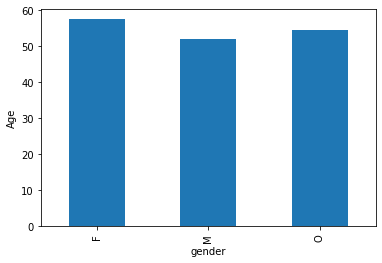

In [8]:
profile.groupby('gender')['age'].mean().plot.bar();
plt.ylabel('Age');

The data has same mean age distribution among the gender.

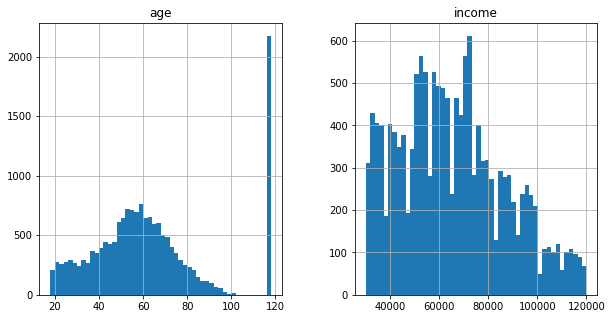

In [9]:
profile[['age','income']].hist(bins=50,figsize=(10,5));

As we can see the age data is nearly a gaussian distribution with 118 as outlier whereas the income data is right skewed.

In [10]:
transcript.head(10)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [11]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [12]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [13]:
transcript.person.nunique()

17000

Transcript data has the transaction details of the 17000 unique person. 4 types of event is regietered, **transaction, offer received and offer viewed** 

The **value** column has either offer id or amount of transaction.  

#### Concatenate profile and transcript column

- first change **became_member_on** column to datetime column
- join datasets on person/id column

In [14]:
profile_data = profile.copy()

In [15]:
# change became_member_on to datetime format and drop the column
profile_data['date'] = pd.to_datetime(profile_data["became_member_on"],format='%Y%m%d')
profile_data.drop('became_member_on',axis=1,inplace=True)

In [16]:
transcript_data = transcript.copy()

In [17]:
# join on person/id column
new_data = transcript_data.join(profile_data.set_index('id'), on = 'person')

Extract offer id and transaction amount and replace the value column

In [18]:
# extract offer id and transaction amount and replace the value column

new_data['value'] = new_data.apply(lambda x : list(x['value'].values())[0],axis = 1)

Change gender from None to unknown

In [19]:
new_data['gender'] = new_data['gender'].apply(lambda x: 'Unknown' if x == None else x)

In [20]:
# check the gender column one more time
new_data.gender.unique()

array(['F', 'Unknown', 'M', 'O'], dtype=object)

In [26]:
new_data.columns

Index(['person', 'event', 'value', 'time', 'gender', 'age', 'income', 'date'], dtype='object')

Since we have **offer id** and **transaction amount** in the same column, we can spit the dataset into offer data and transaction data for further analysis

In [21]:
offer_data = new_data[new_data['event'] != 'transaction']
transaction_data = new_data[new_data['event'] == 'transaction']
#Convert value amount to float
transaction_data = transaction_data.copy() # to avoid settingwithcopy warning
transaction_data.loc[:,'value'] = transaction_data.loc[:,'value'].astype(float)

## Join portfolio data with offer data

This will help us find out what type of offers are more popular among consumers

In [22]:
offer_data = offer_data.join(portfolio.set_index('id'), on = 'value')

In [23]:
offer_data.difficulty.unique()

array([ 5, 20, 10,  7,  0])

In [25]:
offer_data.columns

Index(['person', 'event', 'value', 'time', 'gender', 'age', 'income', 'date',
       'reward', 'channels', 'difficulty', 'duration', 'offer_type'],
      dtype='object')

In [22]:
offer_data.head()

,person,event,value,time,gender,age,income,date,reward,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,F,75,100000.0,2017-05-09,5,"[web, email, mobile]",5,7,bogo
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,Unknown,118,NaN,2017-08-04,5,"[web, email]",20,10,discount
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,0,M,68,70000.0,2018-04-26,2,"[web, email, mobile]",10,7,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4,0,Unknown,118,NaN,2017-09-25,2,"[web, email, mobile, social]",10,10,discount
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,0,Unknown,118,NaN,2017-10-02,10,"[web, email, mobile, social]",10,5,bogo


## What are the popular types of offers?

We can make a plot of what percentage of the distributed offer was BOGO, Discount, and Informational and finally find out what percentage of the offers were received, viewed and completed

In [23]:
# total number of offer received  
offer_received = offer_data[offer_data['event'] == 'offer received']
# total number of offer received grouped by offer type
offer_received.groupby('offer_type')['offer_type'].count()

offer_type
bogo             30499
discount         30543
informational    15235
Name: offer_type, dtype: int64

In [24]:
# percentage of offer received grouped by offer type
(offer_data.groupby(['offer_type','event'])['event'].count()/offer_received.shape[0])

offer_type     event          
bogo           offer completed    0.205422
               offer received     0.399845
               offer viewed       0.333639
discount       offer completed    0.234802
               offer received     0.400422
               offer viewed       0.281146
informational  offer received     0.199733
               offer viewed       0.141996
Name: event, dtype: float64

In [25]:
def offer_type_by_event(data = offer_data):
    """
    Plot of percentage of offer received vs grouped by offer type
    INPUT:
    data : input offer data
    OUTPUT:
    Plot of percentage of offer received vs grouped by offer type
    """
    # total number of offer received  
    offer_received = offer_data[offer_data['event'] == 'offer received']
    # percentage of offer received grouped by offer type
    res = (data.groupby(['offer_type','event'])['event'].count()/offer_received.shape[0])
    res.unstack().plot(kind='bar',rot = 360);
    plt.ylabel('percentage of offer received');
    plt.title('percentage of offer received vs grouped by offer type');

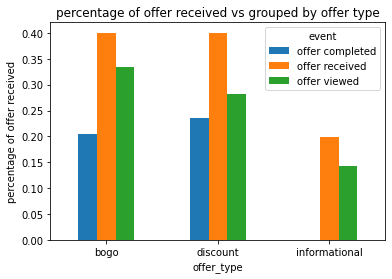

In [26]:
offer_type_by_event()

We can see that the informational offers don't need to be completed. Although, **BOGO and Discount** offers were distributed evenly,

- BOGO offers were viewed more than discount offers.
- But, Discount offers were completed more.

So, discount offers were more popular in terms of completion. 

## Distribution of transaction and offer among gender

let's find out how offer data is distributed with gender.

Since there is no offer completion for 'informational' offer, we can ignore the rows containing 'informational' offer to find out the relation between offer viewed and offer completion 

In [27]:
def average_offer_by_gender(data = offer_data, profile_info = profile_data):
    '''
    Input:
    data : data to plot offer type vs percentage of offer
    profile_info: profile data of all customers
    
    Output:
    plot of gender vs average number of offers
    '''
    res = data[data['event'] == 'offer received'].gender.value_counts()/profile_info.gender.fillna('Unknown').value_counts()
    res.plot.bar();
    plt.title('Average offer received by gender')
    plt.xlabel('Gender')
    plt.ylabel('average offer received per person');

def offer_with_gender(data = offer_data):
    '''
    Input:
    data : data to plot offer type vs percentage of offer
    
    Output:
    plot of offer type vs percentage of offer
    '''
    gender = data.gender.unique()
    cols = ['b','r','g','c']
    for i,gen in enumerate(gender): 
        data = data[data['offer_type'] != 'informational' ]
        res = data[data['gender'] == gen].event.value_counts()
        res[1:] = res[1:]/res[0]
        res[:1] =  res[:1]/data[data['gender'] == gen].shape[0] # divide by total offer data by gender
        plt.bar(np.arange(res.shape[0] - 1)+i/5,res.values[1:],width = 0.20 , color = cols[i],label = gen)
    plt.xticks(np.arange(res.shape[0] - 1) + 0.25, (res.index[1:]))
    plt.xlabel('offer type');
    plt.legend(loc = 'best');
    plt.ylabel('percentage');
    plt.title('distribution of offers by Gender');
    

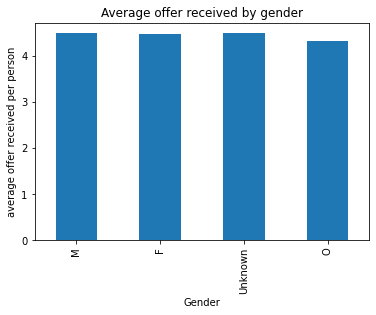

In [28]:
average_offer_by_gender()

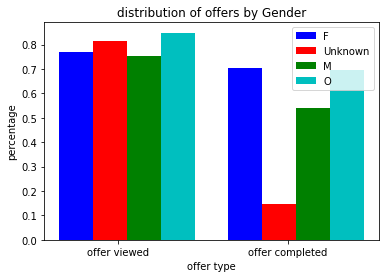

In [29]:
offer_with_gender()

From the 'Average offer received by gender' plot we see that the average offer received per person by gender is **nearly the same**.

The 'distribution of offers by Gender' plot shows the percentage of **offer viewed** among offer received by gender and percentage of **offer completed** among offer received by gender.

Clearly, we see that,
- **Other** customers viewed the most offers and 
- **Male** customers viewed the least offers. 
- **Female** customers completed the most offers and, 
- **Unknown** group completed the least offers. 

We can say, given an offer, the chance of redeeming the offer is higher among **Female** and **Other** genders!

From the transaction data, let's try to find out how **gender,age and income** relates to average transaction amount

In [30]:

def average_transaction(data = transaction_data):
    """
    Plot of avg expenditure vs gender, avg expenditure vs age and avg expenditure vs income
    INPUT:
    data: transaction data
    """
    cols = ['gender','age','income']

    for col in cols:
        data.groupby([col])['value'].mean().plot.bar(figsize = (20,5));
        plt.ylabel('mean transaction');
        plt.title(f'avg expenditure vs {col}')
        plt.show();

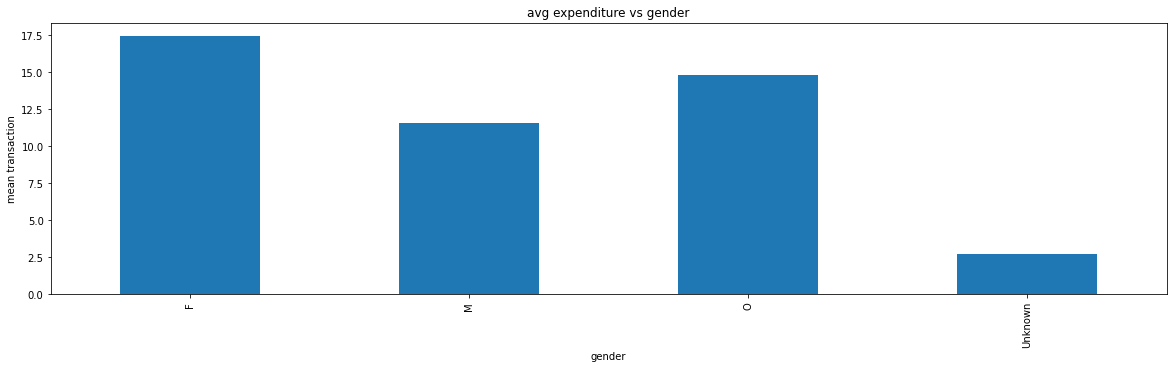

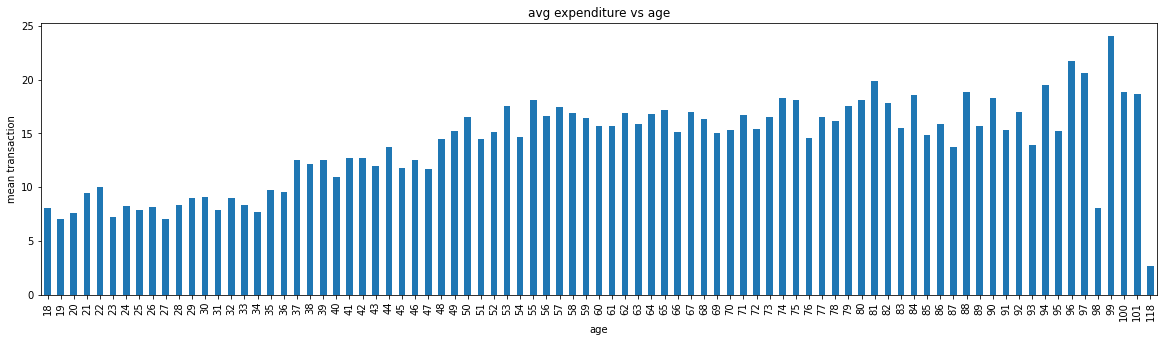

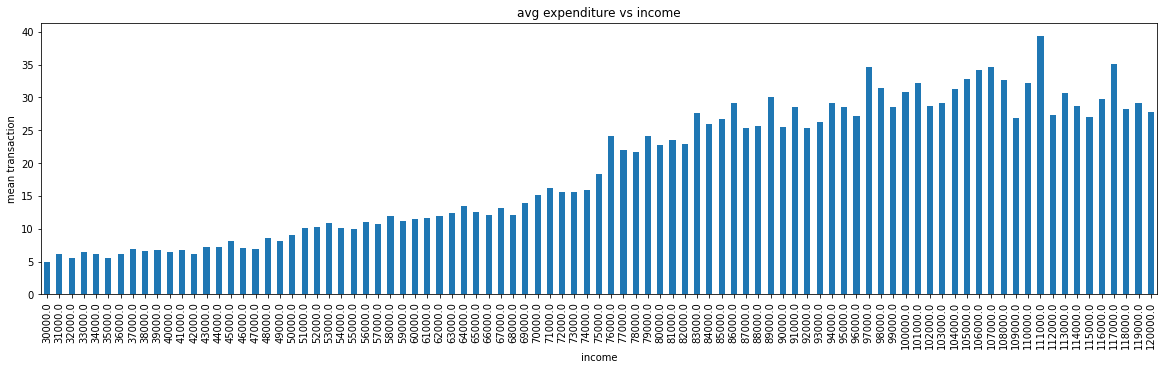

In [31]:
average_transaction()

We can clearly see the expected trend in **age** and **income** vs expenditure. With age and income, mean expenditure increases.

In the gender plot, we see **women** tend to spend the most and group with no demographic data (**Unknown** gender) tend to spend the lowest.

### Building a Recommendation System

I will try to build a recommendation system and try to recommend ideal users for each offer.

We need to remember few things before doing that.

- We need to identify users who completed offers without actually opening the offers. We don't need to send out offers to these users as most likely they don't care about the offers.

- If an user spends an average of more than \\$20, they are most likely don't rely on offers.

- Since we have offer values of \\$5, \\$7, \\$10 and \\$20, we can come up with a general rule, that if an user spends an average of \\$15, we can recommend them a \\$20 offer to spend a little more.
- Finally we would want to make recommendations for new users too. For, that we can train a ML model based on demgraphic data and other features to predict an amount the user will spend. And depending on the value, we can recommend them a offer or not! (for example, if the user is expected to spend more than \\$20, or very less than \\$5). 

In [32]:
offer_data[offer_data['event'] == 'offer completed'].groupby('person')['event'].count()

person
0009655768c64bdeb2e877511632db8f    3
0011e0d4e6b944f998e987f904e8c1e5    3
0020c2b971eb4e9188eac86d93036a77    3
0020ccbbb6d84e358d3414a3ff76cffd    3
003d66b6608740288d6cc97a6903f4f0    3
                                   ..
fff29fb549084123bd046dbc5ceb4faa    6
fff3ba4757bd42088c044ca26d73817a    3
fff7576017104bcc8677a8d63322b5e1    3
fffad4f4828548d1b5583907f2e9906b    3
ffff82501cea40309d5fdd7edcca4a07    6
Name: event, Length: 12774, dtype: int64

We need to be careful on the fact that, a customer can fulfill an offer even without opening an offer. We need to first identify these customers. Let's try to do that. Also, since 'informational' offers don't need to be completed we need to exclude that and add it later. 

let's group the data with respect to **person** and **event**. 

In [33]:
offer_data_informational = offer_data[offer_data['offer_type'] == 'informational']

In [34]:
offer_data_not_informational = offer_data[offer_data['offer_type'] != 'informational']

In [35]:
offer_data_not_informational.groupby(['person','event'])['event'].count().unstack().fillna(0)

event,offer completed,offer received,offer viewed
person,,,
0009655768c64bdeb2e877511632db8f,3.0,3.0,2.0
00116118485d4dfda04fdbaba9a87b5c,0.0,2.0,2.0
0011e0d4e6b944f998e987f904e8c1e5,3.0,3.0,3.0
0020c2b971eb4e9188eac86d93036a77,3.0,4.0,2.0
0020ccbbb6d84e358d3414a3ff76cffd,3.0,3.0,3.0
...,...,...,...
fff3ba4757bd42088c044ca26d73817a,3.0,4.0,2.0
fff7576017104bcc8677a8d63322b5e1,3.0,5.0,4.0
fff8957ea8b240a6b5e634b6ee8eafcf,0.0,2.0,2.0


## How to decide whom to send BOGO, discount and Informational offers?

There can be two possibilities for BOGO and Discount offers, 
- We can set a threshold ratio of **offer viewed/offer received** and say if the value is more than the threshold percentage, they have a better chance of opening an offer.
- Similarly we can set a threshold ratio of **offer completed/offer viewed** and say if the value is more than the threshold percentage, they have a better chance of completing an offer.

But there's a catch! We can have people who actually completed an offer without even opening the offer. In that case the ratio of **offer completed/offer viewed** will be greater than 1. We don't need to send them offers as they will most likely wouldn't mind about offers. So, we need to set an upper bound too!

Finally, we can use the informational offer data, and build a separate recommendation system than BOGO and Discount offers, since one doesn't need to spend anything for this type of offers. 

#### How to build the recommendation system?

For BOGO and Discount offer data,

- We will use **rank based recommendation**
- There will be User-User Based **Collaborative Filtering**, in which, we will recommend top n users for each offer.
- We will use ML to make **content based recommendation** for new users. We will train a model based on demographic data to predict the mean expenditure. Depending on that value, we will recommend offers.

For Informational offers,

- We will use rank based recommendation. Since there are only two offers in this category, we will just predict top n users for similar new offers.

 

In [36]:
# write a function that will split the offer data into offer_type (BOGO, discount vs informational)

def split_offer_data(data = offer_data):
    """
    Function to split offer_data in offer type
    INPUT:
    offer_data : pandas dataframe
    
    OUTPUT:
    informational_offer_data: dataframe containing only 'informational' offer_type
    no_informational_offer_data: dataframe containing 'BOGO and discount' offer_type
    """
    info = data[data['offer_type'] == 'informational']
    no_info = data[data['offer_type'] != 'informational']
    return info, no_info

# function that will return a dataframe with person as index and events as columns

def person_info(data = offer_data):
    """
    Function to return a dataframe with person as index and events as columns

    INPUT:
    offer_data : pandas dataframe  
    
    OUTPUT:
    no_info_person_df : df containing person as index and "offer completed, offer received, offer viewed, completed/viewed, viewed/received" 
    as columns 
    info_person_df : df containing person as index and "offer received, offer viewed,viewed/received" 
    as columns 
    """
    info_data,no_info_data = split_offer_data(data)
    no_info_person_df = no_info_data.groupby(['person','event'])['event'].count().unstack().fillna(0)
    no_info_person_df['completed/viewed'] = (no_info_person_df.loc[:,'offer completed']/no_info_person_df.loc[:,'offer viewed']).fillna(0)
    no_info_person_df['viewed/received'] = (no_info_person_df.loc[:,'offer viewed']/no_info_person_df.loc[:,'offer received']).fillna(0)
    no_info_person_df.replace([np.inf], 0, inplace = True) # inf occurs in completed/viewed col
    
    info_person_df = info_data.groupby(['person','event'])['event'].count().unstack().fillna(0)
    info_person_df['viewed/received'] = (info_person_df.loc[:,'offer viewed']/info_person_df.loc[:,'offer received']).fillna(0)
    
    return no_info_person_df,info_person_df



Let's have a look at the data

In [37]:
no_info_data, info_data = person_info()

In [38]:
no_info_data.describe(percentiles=[0.25,0.75,0.9])

event,offer completed,offer received,offer viewed,completed/viewed,viewed/received
count,16928.000000,16928.000000,16928.000000,16928.000000,16928.000000
mean,1.983637,3.605978,2.770203,0.738188,0.771803
std,1.603787,1.183817,1.252258,0.636747,0.256611
min,0.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,2.000000,0.000000,0.600000
50%,2.000000,4.000000,3.000000,0.750000,0.800000
75%,3.000000,4.000000,4.000000,1.000000,1.000000
90%,4.000000,5.000000,4.000000,1.500000,1.000000
max,6.000000,6.000000,6.000000,5.000000,1.000000


In [39]:
info_data.describe()

event,offer received,offer viewed,viewed/received
count,10547.000000,10547.000000,10547.000000
mean,1.444487,1.026927,0.711436
std,0.664753,0.737906,0.412456
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.500000
50%,1.000000,1.000000,1.000000
75%,2.000000,1.000000,1.000000
max,5.000000,5.000000,1.000000


**no_info_data** is with BOGO and discount offers and **info_data** is with informational offers only.

Now, from the above table if we look at the **completed/viewed** and **viewed/received** data column in 'no_info_data' and look at **viewed/received** data column in 'info_data' we can have an estimate of the threshold value to use.

-no_info_data: completed/viewed has a **mean of 0.74** and **1.5 is the 90th percentile** of the data. viewed/received has **mean 0.77** and **1 is the 90th percentile** of the data.

-info_data: viewed/received has **mean 0.71** and **1 is the 75th pecentile** of the data.

## Rank based recommendation:

In this method we will return n top person for BOGO/discount offers and n top person for informational offers. They will be qualified for future similar offers.

In [40]:
def get_n_top_info_user(data = offer_data, threshold = 0.7, topn = 10):
    """
    Function to return n top info offer users for future offers
    INPUT:
    offer_data : pandas dataframe
    threshold: only select users who viewed atleast threshold of the offers 
    topn: top users to return
    OUTPUT:
    array of n top users/ all users for topn = 'max'
    """
    
    _ , info_data = person_info(data)
    
    info_data = info_data[info_data['viewed/received'] > threshold].sort_values(by=['viewed/received','offer received'],ascending = False)
    
    if type(topn) == int:
        return info_data[:topn].index.values
    if topn == 'max':
        return info_data.index.values
    else:
        print ("Enter the correct topn, either 'max' of integer")


To get n top non info users first we will filter out user according to certain threshold values in 'viewed/received' and 'completed/viewed' coulmns. Then we will look at their mean transaction value. If the value is greater than 20 then we will discard that user, as the greatest offer is \\$5 discount on \\$20 purchase. So the user doesn't care about the offers.

In [41]:
def get_n_top_non_info_user(data1 = offer_data, data2 = transaction_data, completed_thresh_lower = 0.7,completed_thresh_upper = 1.5,viewed_thresh = 0.75,topn = 10):
    """
    Function to return n top non info offer users for future offers
    INPUT:
    data1 : pandas dataframe of offer data
    data2 : pandas dataframe of transaction data
    completed_thresh_lower : users who completed atleast the given value of the offers
    completed_thresh_upper : users who completed less than the given value of the offers
    viewed_thresh : select users who viewed atleast the given of the offers
    topn: top users to return
    OUTPUT:
    n top users
    """
    no_info_data ,_ = person_info(data1)
    mean_transaction = data2.groupby(['person'])['value'].mean()
    #discard users spending more than $20 
    mean_transaction [mean_transaction <= 20.0 ] # value of higest offer value
    # Filter no_info_data according to the threshold value
    no_info_data = no_info_data.loc[(no_info_data['viewed/received'] > viewed_thresh) & (no_info_data['completed/viewed'] > completed_thresh_lower) & (no_info_data['completed/viewed'] < completed_thresh_upper)]
    no_info_data = no_info_data.join(mean_transaction,on = 'person').dropna()
    no_info_data = no_info_data.sort_values(by=['viewed/received','completed/viewed','offer received','value'],ascending = False)
    
    if type(topn) == int:
        return no_info_data[:topn].index.values
    if topn == 'max':
        return no_info_data.index.values
    else:
        print ("Enter the correct topn, either 'max' of integer")




In [42]:
get_n_top_info_user(topn = 5)

array(['23d67a23296a485781e69c109a10a1cf',
       '6dba14f698ae4030ab7354cd5cfe7119',
       'eece6a9a7bdd4ea1b0f812f34fc619d6',
       '05bbe7decb6d43b684221df448979612',
       '116b28e2983c44039eb8b20292742c94'], dtype=object)

In [43]:
get_n_top_non_info_user(topn = 5)

array(['d167940f7af04f4681daaa6d1bfd80a1',
       'a2633655a62e4287a3b651d926a774a6',
       '4d4216b868fe43ddb9c9f0b77212c0cb',
       'bb465e90882143b6a49f99d9d810dc3f',
       '17b29dcb0f924294a0d1de2ca59c763f'], dtype=object)

#### User-User Based Collaborative Filtering for BOGO/Discount data

Now that we have created a rank-based recommendation for new offers, **what if we want to send out the existing offers to our existing users who haven't received some offers yet?** 

We will try to find top n users for each existing offer. To do so we will create a user_item matrix.

- We will reformat the offer_data dataframe to be shaped with users as the columns and offers as the rows.
- Each user should only appear in each coulmn once.
- Each offer should only show up in one row.
- If a user has interacted with an offer, then place a 1 where the user-column meets for that offer-row. It does not matter how many times a user has interacted with the offer, all entries where a user has interacted with an offer should be a 1.
- If a user has not interacted with an offer, then place a zero where the user-column meets for that offer-row.


In [44]:
user_item = offer_data.groupby(['value','person'])['person'].count().unstack().fillna(0)

In [45]:
user_item.iloc[user_item > 0] = 1

In [46]:
user_item

person,0009655768c64bdeb2e877511632db8f,00116118485d4dfda04fdbaba9a87b5c,0011e0d4e6b944f998e987f904e8c1e5,0020c2b971eb4e9188eac86d93036a77,0020ccbbb6d84e358d3414a3ff76cffd,003d66b6608740288d6cc97a6903f4f0,00426fe3ffde4c6b9cb9ad6d077a13ea,004b041fbfe44859945daa2c7f79ee64,004c5799adbf42868b9cff0396190900,005500a7188546ff8a767329a2f7c76a,...,ffecb1f8543f4bf7bade023de366d6bf,ffed75d3abc64b488982f50ed12878b5,ffede3b700ac41d6a266fa1ba74b4f16,fff0f0aac6c547b9b263080f09a5586a,fff29fb549084123bd046dbc5ceb4faa,fff3ba4757bd42088c044ca26d73817a,fff7576017104bcc8677a8d63322b5e1,fff8957ea8b240a6b5e634b6ee8eafcf,fffad4f4828548d1b5583907f2e9906b,ffff82501cea40309d5fdd7edcca4a07
value,,,,,,,,,,,,,,,,,,,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2906b810c7d4411798c6938adc9daaa5,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3f207df678b143eea3cee63160fa8bed,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
5a8bc65990b245e5a138643cd4eb9837,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
ae264e3637204a6fb9bb56bc8210ddfd,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [47]:

def create_user_item_matrix(df = offer_data):
    '''
    INPUT:
    df - pandas dataframe with person, event, value... columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as columns and value on the rows with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    user_item = offer_data.groupby(['value','person'])['person'].count().unstack().fillna(0)
    user_item.iloc[user_item > 0] = 1
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix()

In [48]:
user_item

person,0009655768c64bdeb2e877511632db8f,00116118485d4dfda04fdbaba9a87b5c,0011e0d4e6b944f998e987f904e8c1e5,0020c2b971eb4e9188eac86d93036a77,0020ccbbb6d84e358d3414a3ff76cffd,003d66b6608740288d6cc97a6903f4f0,00426fe3ffde4c6b9cb9ad6d077a13ea,004b041fbfe44859945daa2c7f79ee64,004c5799adbf42868b9cff0396190900,005500a7188546ff8a767329a2f7c76a,...,ffecb1f8543f4bf7bade023de366d6bf,ffed75d3abc64b488982f50ed12878b5,ffede3b700ac41d6a266fa1ba74b4f16,fff0f0aac6c547b9b263080f09a5586a,fff29fb549084123bd046dbc5ceb4faa,fff3ba4757bd42088c044ca26d73817a,fff7576017104bcc8677a8d63322b5e1,fff8957ea8b240a6b5e634b6ee8eafcf,fffad4f4828548d1b5583907f2e9906b,ffff82501cea40309d5fdd7edcca4a07
value,,,,,,,,,,,,,,,,,,,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2906b810c7d4411798c6938adc9daaa5,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3f207df678b143eea3cee63160fa8bed,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
5a8bc65990b245e5a138643cd4eb9837,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
ae264e3637204a6fb9bb56bc8210ddfd,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


We will write a function below which should take a person and provide an ordered list of the most similar users to that user (from most similar to least similar). The returned result should not contain the provided person, as we know that each user is similar to them. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users.

In [49]:
def find_similar_offers(offer, user_item=user_item):
    '''
    INPUT:
    person - (string) an offer
    user_item - (pandas dataframe) matrix of offers by users: 
                1's when a user has interacted with an offer, 0 otherwise
    
    OUTPUT:
    similar_offes - (list) an ordered list where the closest offers (largest dot product offers)
                    are listed first
    
    Description:
    Computes the similarity of every pair of offers based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided offer
    similar_offers_matrix = user_item.dot(np.transpose(user_item))

    # sort by similarity
    most_similar_offers = similar_offers_matrix.loc[offer].sort_values(ascending=False)

    # create list of just the ids
    most_similar_offers = list(most_similar_offers.index)
   
    # remove the own user's id
    most_similar_offers.remove(offer)   
    return most_similar_offers # return a list of the offers in order from most to least similar

In [50]:
find_similar_offers('9b98b8c7a33c4b65b9aebfe6a799e6d9')[:5]

['3f207df678b143eea3cee63160fa8bed',
 '5a8bc65990b245e5a138643cd4eb9837',
 'ae264e3637204a6fb9bb56bc8210ddfd',
 '4d5c57ea9a6940dd891ad53e9dbe8da0',
 'fafdcd668e3743c1bb461111dcafc2a4']

In [51]:
def get_offer_user(offer, user_item=user_item):
    '''
    INPUT:
    offer - (srting) an offer
    user_item - (pandas dataframe) matrix of offers by users: 
                1's when a user has interacted with an offer, 0 otherwise
    
    OUTPUT:
    person - (list) a list of people who received the offer
    
    Description:
    Provides a list of people who received the offer
    '''
    # Your code here
    person_idx = np.where(user_item.loc[offer] == 1)[0]
    person_ids = user_item.columns[person_idx].tolist()
    person_ids = np.array(person_ids).astype(str)
    return person_ids # return the ids 

def offer_offer_recs(offer, m=10):
    '''
    INPUT:
    offer - (srting) an offer
    m - (int) the number of person you want for the offer
    
    OUTPUT:
    recs - (list) a list of recommendations for the offer
    
    Description:
    Loops through the offers based on closeness to the input offer
    For each offer - finds persons the offer wasn't sent before and provides them as recs
    Does this until m people are found
    
    '''
    
    recs = []
    sim_offers = find_similar_offers(offer)
    person_ids = get_offer_user(offer)
    for offer in sim_offers:
        rec_people = get_offer_user(offer)
        temp_recs = np.setdiff1d(rec_people, person_ids,assume_unique=True)
        recs.extend(temp_recs)
        # If there are more than m 
        if len(recs) >= m:
            break
    if len(recs) < m:
        return recs
    else:
        return recs[:m]

In [52]:
get_offer_user('3f207df678b143eea3cee63160fa8bed', user_item=user_item)

array(['0009655768c64bdeb2e877511632db8f',
       '0011e0d4e6b944f998e987f904e8c1e5',
       '003d66b6608740288d6cc97a6903f4f0', ...,
       'ffd810f301ad42d6bfe98c4ba6ee4125',
       'fff0f0aac6c547b9b263080f09a5586a',
       'fff8957ea8b240a6b5e634b6ee8eafcf'], dtype='<U32')

In [53]:
offer_offer_recs('3f207df678b143eea3cee63160fa8bed', m=10)

['0020ccbbb6d84e358d3414a3ff76cffd',
 '005500a7188546ff8a767329a2f7c76a',
 '0063def0f9c14bc4805322a488839b32',
 '00857b24b13f4fe0ad17b605f00357f5',
 '0092a132ead946ceb30d11a1ed513d20',
 '00ad4c2cace94f67a6354ec90d6c6f45',
 '00b5fb9d842d437e83033ad9e36f7148',
 '00b901d68f8f4fd68075184cd0f772d2',
 '00bbce6533f44ddeaf4dd32bcab55441',
 '00bc983061d3471e8c8e74d31b7c8b6f']

**offer_offer_recs** will give us n number of users who haven't received a particular offer. 

We can improve the recommendation in combination with the ranked based recommendation.
- Instead of arbitrarily choosing when we obtain offers who are all the same closeness to a given offer - choose the offers that have the most total people interactions before choosing those with fewer people interactions.
- Instead of arbitrarily choosing users from the offer where the number of recommended persons starts below m and ends exceeding m, choose persons with the most total interactions before choosing those with fewer total interactions.


In [54]:
def get_top_sorted_offers(offer, df=offer_data, user_item=user_item):
    '''
    INPUT:
    offer - (str)
    df - (pandas dataframe) offer data
    user_item - (pandas dataframe) matrix of offers by users: 
                1's when a user has interacted with an offer, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor offer
                    similarity - measure of the similarity of each offer to the provided offer
                    num_interactions - the number of users received the offer
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
      
    
    # measure of the similarity of each user to the provided user_id
    similar_offers_matrix = user_item.dot(np.transpose(user_item))
    similarity = similar_offers_matrix.loc[offer].drop(offer)
    
    # The number of articles viewed by the user
    num_interactions = df.groupby('value')['person'].count().drop(offer)
    
    neighbor_id = num_interactions.index

    neighbors_dict = {'neighbor_id':neighbor_id,'similarity':similarity,'num_interactions':num_interactions}
    neighbors_df = pd.DataFrame(neighbors_dict)
    
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
    
    return neighbors_df.reset_index(drop=True) # Return the dataframe specified in the doc_string


def offer_offer_recs_improved(offer, m=10):
    '''
    INPUT:
    offer - (srting) an offer
    m - (int) the number of person you want for the offer
    
    OUTPUT:
    recs - (list) a list of recommendations for the offer
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    '''

    recs = []
    sim_offers = get_top_sorted_offers(offer)['neighbor_id'].values.tolist()
    person_ids = get_offer_user(offer)
    for offer in sim_offers:
        rec_people = get_offer_user(offer)
        temp_recs = np.setdiff1d(rec_people, person_ids,assume_unique=True)
        recs.extend(temp_recs)
        # If there are more than m 
        if len(recs) >= m:
            break
    if len(recs) < m:
        return recs
    else:
        return recs[:m]
    
    return recs

In [55]:
get_top_sorted_offers('3f207df678b143eea3cee63160fa8bed')

,neighbor_id,similarity,num_interactions
0,fafdcd668e3743c1bb461111dcafc2a4,2147.0,20241
1,9b98b8c7a33c4b65b9aebfe6a799e6d9,2147.0,16202
2,4d5c57ea9a6940dd891ad53e9dbe8da0,2130.0,18222
3,2298d6c36e964ae4a3e7e9706d1fb8c2,2119.0,20139
4,5a8bc65990b245e5a138643cd4eb9837,2104.0,14305
5,0b1e1539f2cc45b7b9fa7c272da2e1d7,2083.0,13751
6,ae264e3637204a6fb9bb56bc8210ddfd,2073.0,18062
7,f19421c1d4aa40978ebb69ca19b0e20d,2072.0,19131
8,2906b810c7d4411798c6938adc9daaa5,2034.0,15767


In [56]:
offer_offer_recs_improved('3f207df678b143eea3cee63160fa8bed')

['0020c2b971eb4e9188eac86d93036a77',
 '00426fe3ffde4c6b9cb9ad6d077a13ea',
 '004c5799adbf42868b9cff0396190900',
 '0099bf30e4cb4265875266eb3eb25eab',
 '00b18b535d6d4f779dea4dc9ac451478',
 '00b5fb9d842d437e83033ad9e36f7148',
 '00b901d68f8f4fd68075184cd0f772d2',
 '00bbce6533f44ddeaf4dd32bcab55441',
 '00bc42a62f884b41a13cc595856cf7c3',
 '00c2f812f4604c8893152a5c6572030e']

Now, since we have built a recommendation system which recommends n persons for each offer, we can imporve it further in combination with a ranked based recommendation. We used some filtering to get top n persons for informational offer and BOGO/discount offer. In **get_n_top_non_info_user** **get_n_top_info_user** funtions, if we set topn = 'max' we will get all possible users.

Finally combine offer_offer_recs_improved function to get n top persons within the database created by the above mentiones functions.

In [57]:
def make_recs(offer,m = 10):
    '''
    INPUT:
    offer - (srting) an offer
    m - (int) the number of person you want for the offer
    
    OUTPUT:
    recs - (list) a list of recommendations for the offer
    '''
    total_users = np.union1d(get_n_top_info_user(topn = 'max'),get_n_top_non_info_user(topn = 'max'))
    recs = offer_offer_recs_improved(offer,m)
    total_recs = np.intersect1d(recs,total_users)
    while total_recs.shape[0] < m:
        recs = offer_offer_recs_improved(offer,m - total_recs.shape[0])
        recs = np.intersect1d(recs,total_users)
        if (recs.shape[0] > 0):
            total_recs = np.concatenate((total_recs , recs))
        else:
            break
    return total_recs
        

In [58]:
make_recs('4d5c57ea9a6940dd891ad53e9dbe8da0')

array(['0009655768c64bdeb2e877511632db8f',
       '0011e0d4e6b944f998e987f904e8c1e5',
       '003d66b6608740288d6cc97a6903f4f0',
       '004b041fbfe44859945daa2c7f79ee64',
       '0056df74b63b4298809f0b375a304cf4',
       '0082fd87c18f45f2be70dbcbb0fb8aad',
       '00c6035df45840038a72766c6d27a0db',
       '0009655768c64bdeb2e877511632db8f',
       '0011e0d4e6b944f998e987f904e8c1e5',
       '003d66b6608740288d6cc97a6903f4f0'], dtype=object)

### Use ML to make content based recommendation for new users.

To train an ML model we will use "transaction_data".

- We want to predict the value column, given the demograpic information.
- In this data, 'person','event','time', and 'date' column is not necessary.
- we will groupby the data by 'person' and try to predict the mean value.

In [32]:
# Data preparation

def data_load(df = transaction_data):
    '''
    INPUT:
    df - (DataFrame) pandas dataframe of transaction data
    
    OUTPUT:
    X: Featurs (gender,age,income columns)
    y: target variable(value column)
    non_demo_data: mean value of the non demograpic data
    Description:
    Drop 'event','time','date' columns from the dataframe, groupby the data 
    by 'person' column.
    Take mean of value calumn and max/min of the other columns 
    
    '''
    new_df = df.drop(['event','time','date' ],axis = 1)
    non_demo_value = np.round(new_df[new_df['age'] == 118]['value'].median(),decimals = 2)
    new_df = new_df[new_df['age'] != 118] # remove outliers
    # groupby person
    new_df = new_df.groupby('person',as_index = False) 

    X = new_df[['gender','income','age']].max()
    X.drop('person',axis=1,inplace=True) #Drop person column
    y = np.round(new_df['value'].median(),decimals = 2)
    y.drop('person',axis=1,inplace=True) #Drop person column
    return X,y,non_demo_value

#### Data preprocessing

In [33]:
X_data,y_data,non_demo_val = data_load()

In [98]:
non_demo_val

1.71

In [36]:
X_data.head(10)

,gender,income,age
0,M,72000.0,33
1,O,57000.0,40
2,F,90000.0,59
3,F,60000.0,24
4,F,73000.0,26
5,F,65000.0,19
6,F,74000.0,55
7,M,99000.0,54
8,M,47000.0,56
9,M,91000.0,54


In [72]:
X_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14492 entries, 0 to 14491
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gender  14492 non-null  object 
 1   income  14492 non-null  float64
 2   age     14492 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 452.9+ KB


In [73]:
y_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14492 entries, 0 to 14491
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   14492 non-null  float64
dtypes: float64(1)
memory usage: 226.4 KB


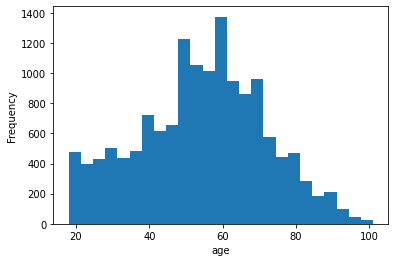

In [43]:
X_data['age'].plot.hist(bins = 25);
plt.xlabel('age');


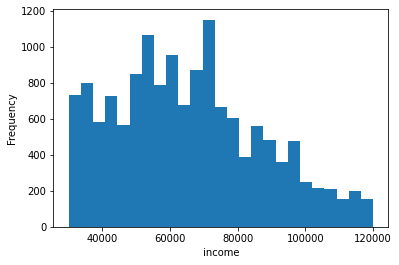

In [46]:
X_data['income'].plot.hist(bins = 25);
plt.xlabel('income');


**How did we handle NaN values?**
From the analysis so far, we know that there are some rows with no demographic information. These rows have **age = 118, gender = Unknown and income = NaN**.


Since we know, these NaN values are correlated with no information. So we can treat them as outliers, we can simply filter out the value and calculate the median expenditure and use that value if a new customer doesn't provide any demographic data. 

#### Data preprocessing using SKLearn



**Preprocessing Categorical Attribute**

In [62]:
#Ref: https://harshit-tyagi.medium.com/end-to-end-machine-learning-project-tutorial-part-1-ea6de9710c0
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,FunctionTransformer,PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import svm

cat_encoder = OneHotEncoder()
data_cat_1hot = cat_encoder.fit_transform(X_data[['gender']])
#data_cat_1hot   # returns a sparse matrix
data_cat_1hot.toarray()[:5]

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

**Imputation of numerical values**

In [63]:
# not needed
from sklearn.impute import SimpleImputer
imp = SimpleImputer(fill_value=0.01, strategy='constant')
imp.fit_transform(X_data[['income','age']])


array([[7.2e+04, 3.3e+01],
       [5.7e+04, 4.0e+01],
       [9.0e+04, 5.9e+01],
       ...,
       [5.6e+04, 7.1e+01],
       [3.4e+04, 3.4e+01],
       [6.2e+04, 4.5e+01]])

In [64]:


def numerical_trasnform(df):
    '''
    INPUT:
    df - (DataFrame) pandas dataframe 
    
    OUTPUT:
    num_attr : numerical attributes
    num_pipeline: numerical pipeline object
    Description:
    Using Scikit learn to impute NaN values, and standadize     
    '''
    nums = ['float64','int64']
    
    num_attr = df.select_dtypes(include = nums)
    
    num_pipeline = Pipeline([
        #('impute',SimpleImputer(fill_value=0.01, strategy='constant')),
        ('log',FunctionTransformer(np.log)),
        ('std_scaler', StandardScaler()),
        ('poly',PolynomialFeatures(2,interaction_only=False,include_bias = False))
        
    ])
    
    return num_attr,num_pipeline
    

In [65]:
##creating custom attribute adder class

class CustomAttrAdder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        extra = []
        for i in X[:,:-4].T:
            extra.append(i.reshape(-1,1)*X[:,-4:])
        extra = np.hstack(extra)
        return np.c_[X, extra]

In [66]:
def full_data_pipeline(df):
    """
    INPUT:
    df - (DataFrame) pandas dataframe 
    
    OUTPUT:
    full_data_pipeline : final prepared data pipeline to feed into the ML model
    Description:
    full data transformation pipeline for both numerical and categorical data
    """
    cat_attr = ["gender"]
    
    num_attr,num_pipeline = numerical_trasnform(df)
    full_data_pipeline = ColumnTransformer([
        ('num',num_pipeline,list(num_attr)),
        ('cat',OneHotEncoder(),cat_attr),
        ])
    
    
#     full_data_pipeline = Pipeline([
#         ('transform',ColumnTransformer([
#         ('num',num_pipeline,list(num_attr)),
#         ('cat',OneHotEncoder(),cat_attr),
#         ])),
#         ('custom',CustomAttrAdder())            
#     ])
    
    return full_data_pipeline
    

## Train an ML model

Since this is a regression problem, we can use various regression methods to find the best model.

I used:
- Linear Regression
- Random Forest Regression
- SVM Regressor
- XGBoost regressor

In [1170]:
#REF : https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

# def rf_model(df):
#     """
#     OUTPUT:
#     full_pipeline : full pipeline of the the ML model
#     """
#     preprocessing = full_data_pipeline(df)
#     rf = Pipeline([
#         ('preprocess',preprocessing),
#         ('rf_regressor', RandomForestRegressor(random_state=42))
#     ])
    
#     return rf 

In [1171]:
# def lin_model(df):
#     """
#     OUTPUT:
#     full_pipeline : full pipeline of the the ML model
#     """
#     preprocessing = full_data_pipeline(df)
#     lin = Pipeline([
#         ('preprocess',preprocessing),
#         ('lin_regressor', LinearRegression())
#     ])
    
#     return lin

In [1172]:
# def sup_model(df):
#     """
#     OUTPUT:
#     full_pipeline : full pipeline of the the ML model
#     """
#     preprocessing = full_data_pipeline(df)
#     sup = Pipeline([
#         ('preprocess',preprocessing),
#         ('svm_regressor', svm.SVR())
#     ])
    
#     return sup

In [47]:
# def xgb_model(df):
#     """
#     OUTPUT:
#     full_pipeline : full pipeline of the the ML model
#     """
#     preprocessing = full_data_pipeline(df)
#     xgb = Pipeline([
#         ('preprocess',preprocessing),
#         ('xgb_regressor', xgb.XGBRegressor())
#     ])
    
#     return xgb

In [50]:
#rf = rf_model(df = X_train)

In [51]:
#lin = lin_model(df = X_train)

In [52]:
#sup = sup_model(df = X_train)

In [53]:
#xgb = xgb_model(df = X_train)

In [1077]:
#rf.score(X_train,y_train.values.ravel())

0.694306381831229

In [1078]:
#rf.score(X_test,y_test.values.ravel())

0.14857503322125365

In [835]:
#rf.predict(X_test)

array([ 3.62857107, 18.3383485 , 16.73058028, ...,  6.75458664,
       37.82519002,  3.44282618])

In [836]:
#y_train.values.ravel()

array([11.61588235,  1.86545455,  8.468     , ..., 24.215     ,
        2.2075    ,  3.115     ])

In [837]:
#lin.fit(X_train,y_train.values.ravel())

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('transform',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('impute',
                                                                                    SimpleImputer(fill_value=0.01,
                                                                                                  strategy='constant')),
                                                                                   ('std_scaler',
                                                                                    StandardScaler())]),
                                                                   ['income',
                                                                    'age']),
                                                                  ('cat',
                                                                   OneHotEncoder(),
  

In [838]:
#lin.score(X_train,y_train.values.ravel())

0.2914412469826335

In [839]:
#lin.score(X_test,y_test.values.ravel())

0.3271854486907245

In [840]:
#sup.fit(X_train,y_train.values.ravel())

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('transform',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('impute',
                                                                                    SimpleImputer(fill_value=0.01,
                                                                                                  strategy='constant')),
                                                                                   ('std_scaler',
                                                                                    StandardScaler())]),
                                                                   ['income',
                                                                    'age']),
                                                                  ('cat',
                                                                   OneHotEncoder(),
  

In [725]:
#sup.score(X_train,y_train.values.ravel())

0.29104689054679533

In [726]:
#sup.score(X_test,y_test.values.ravel())

0.32910751744995914

In [67]:
pipe = full_data_pipeline(X_data)

X_data_mod = pipe.fit_transform(X_data)

In [69]:
xtrain,xtest,ytrain,ytest = train_test_split(X_data_mod, y_data.values.clip(0,25).ravel(), test_size=0.2, random_state=42)

In [87]:
import xgboost as xgb

In [88]:
xgb_reg = xgb.XGBRegressor(base_score=0.75, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=5,
             min_child_weight=4,n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [89]:
xgb_reg.fit(xtrain,ytrain)

XGBRegressor(base_score=0.75, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=5,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [90]:
xgb_reg.score(xtrain,ytrain)

0.726548007942611

In [91]:
xgb_reg.score(xtest,ytest)

0.7019676940584976

In [92]:
xgb_reg.predict(xtest)[:10]

array([ 3.4892423,  3.6517236, 19.297014 , 23.878523 , 22.42564  ,
       10.138913 , 13.73885  ,  5.864456 , 23.411655 , 20.379955 ],
      dtype=float32)

In [93]:
ytest[:10]

array([ 2.78,  7.24, 24.34, 25.  , 25.  ,  3.4 , 12.33,  3.31, 24.13,
       20.75])

In [94]:
booster = ['gbtree','gblinear']
base_score = [0.25,0.5,0.75,1]
n_estimators = [100,500,900,1100,1500]
max_depth = [2,3,5,10,15]
learning_rate = [0.05,0.1,0.15,0.20]
min_child_weight = [1,2,3,4]

hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth' : max_depth,
    'learning_rate' : learning_rate,
    'min_child_weight' : min_child_weight,
    'booster' : booster,
    'base_score': base_score
}

In [97]:
from sklearn.model_selection import RandomizedSearchCV
random_cv = RandomizedSearchCV(estimator = xgb_reg,
                              param_distributions = hyperparameter_grid,
                              cv = 5, n_iter = 10,
                              scoring = 'neg_mean_absolute_error',n_jobs = -1,
                              verbose = 5,
                              return_train_score = True,
                              random_state = 42)

In [98]:
random_cv.fit(xtrain,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.75, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.01, max_delta_step=0,
                                          max_depth=5, min_child_weight=4,
                                          missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=500, n_jobs=8,
                                          num_parallel_...
                                          tree_method='exact',
                                          validate_parameters=1,
                   

In [99]:
random_cv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=3,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [105]:
random_cv.best_estimator_.feature_importances_

array([0.81762344, 0.02484067, 0.00498251, 0.00647093, 0.00605081,
       0.0258556 , 0.10981078, 0.00436528], dtype=float32)

In [102]:
random_cv.predict(xtest)[:10]

array([ 3.6298957,  3.5469856, 18.909605 , 22.456886 , 22.085714 ,
        9.333325 , 13.371367 ,  5.7111363, 23.45266  , 20.470911 ],
      dtype=float32)

In [103]:
ytest[:10]

array([ 2.78,  7.24, 24.34, 25.  , 25.  ,  3.4 , 12.33,  3.31, 24.13,
       20.75])

In [104]:
from sklearn.metrics import mean_squared_error

mean_squared_error(ytest, random_cv.predict(xtest), squared=False)

4.652565341873455

In [112]:
final_model = random_cv.best_estimator_

In [55]:
def predict_expense(demographics,model):
    if type(demographics) == dict:
        df= pd.DataFrame(demographics)
    else:
        df = demographics
    data_pipe = full_data_pipeline(X_data)
    prep_data = data_pipe.fit_transform(df)
    y_pred = model.predict(prep_data)
    
    return np.round(y_pred,decimals=2)

In [57]:
person_demo = {
    'gender' : ['M','F','O'],
    'income' : [60000.0,72000.0,80000.0],
    'age' : [36,26,30]
}

#predict_expense(person_demo,final_model)

**Save The Model**

In [71]:
import pickle

In [117]:
##saving the model
with open("finalmodel.bin", 'wb') as fout:
    pickle.dump(final_model, fout)
    fout.close()

In [72]:
# load the model

with open('finalmodel.bin', 'rb') as fin:
    final_model = pickle.load(fin)

predict_expense(person_demo, final_model)

array([ 3.78, 10.66, 22.26], dtype=float32)

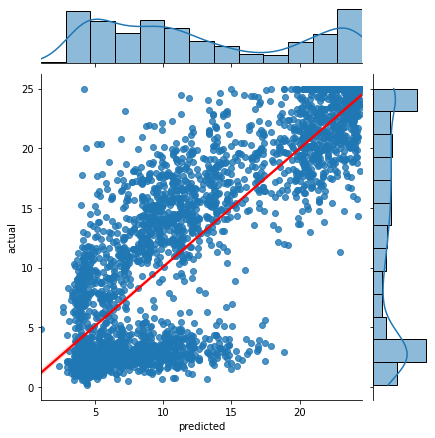

In [95]:

ax = sns.jointplot(x = final_model.predict(xtest),y = ytest, kind = 'reg',joint_kws={'line_kws':{'color':'red'}});

ax.set_axis_labels(xlabel='predicted', ylabel='actual');

Finally, we can set a rule for sending out coupons to new users.
- A person with no demographic data is expected to spend \\$1.71, so we can send out an **Informational offer or No offer!**
- If a user is expected to spend < \\$3 or > \\$22, send out an **Informational offer or No offer!**
- If a user is expected to spend ≥ $3 and < \\$5, send out the **\\$5 coupon offers.**
- If a user is expected to spend ≥ \\$5 and < \\$7, send out the **\\$7 coupon offer.**
- If a user is expected to spend ≥ \\$7 and < \\$10, send out the **\\$10 coupons.**
- Lastly, If a user is expected to spend ≥ \\$10 and < \\$20, send out the **\\$20 coupon.**

**Example:**

predict_expense(person_demo, final_model)

array([ 3.78, 10.66, 22.26], dtype=float32)


- Person 1: gender = Male, income = 60000.00, age = 36. Expected to spend \\$3.78, so send out a \\$5 coupon.
- Person 2: gender = Female, income = 72000.00, age = 26. Expected to spend \\$10.66, so send out a  \\$20 coupon.
- Person 3: gender = Other, income = 80000.00, age = 30. Expected to spend \\$22.26, so send out a Informational coupon/no coupon at all!